# Adiabatic Decompression melting of peridotite and pyroxenite mantle sources

- One of the principal uses of pMELTS (Ghiorso et al. 2002) is simulating mantle melting during adiabatic decompression.
- Alternative thermodynamic models (e.g., Holland et al. 2018) have also been used to simulate mantle melting in the literature, with the most recent iteration of these models implemented through MAGEMin (Green et al. 2025; Riel et al. 2022).
- PetThermoTools allows the user to run melting simulations using either thermodynamic model and compare these results to recent empirical parameterisations of mantle melting (pyMelt; Matthews et al. 2022).

**Before any calculations can be run** users need to download the alphaMELTS for Python files. Please see the installation guide on ReadTheDocs.

Additionally, much of the code presented here represents calculations performed using MAGEMin, not alphaMELTS for Python. As a result, please ensure that you've followed the instructions for installing juliacall and MAGEMinCalc (see associated notebook).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import petthermotools as ptt

In [3]:
# used to suppress MELTS outputs in MacOS systems (run twice)
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

## Examining the influence of source lithology on melting behaviours

First, we'll simulate adiabatic decompression melting of a mantle peridotite at 'typical' mantle potential temperatures (T$_p$ ~ 1500 $^o$C), with melting terminating at ~2 kbar, representing the type of conditions we might expect for decompression melting beneath a mid-ocean ridge.

The calculation is easy to set up. In this case we set up a list of Models to use (pMELTS and Green et al. (2025)), and select the pre-defined bulk composition of the KLB-1 peridotite. We loop through the model list to perform the calculations between 30 kbar (3.0 GPa) and 2000 bars (0.2 GPa).

In [4]:
Model = ['pMELTS','Green2025']
Results = {}
for m in Model:
    Results[m] = ptt.AdiabaticDecompressionMelting(Model = m, bulk = "KLB-1",
        Tp_C = 1350.0, P_start_bar = 30000.0, P_end_bar = 2000.0, dp_bar = 200.0)

PetThermoTools includes a `phase_plot` function that, when the y-axis is specified as `P_bar`, will plot the mass fraction of each phase against pressure during the mantle melting calculations.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='Mass fraction', ylabel='Pressure (bar)'>)

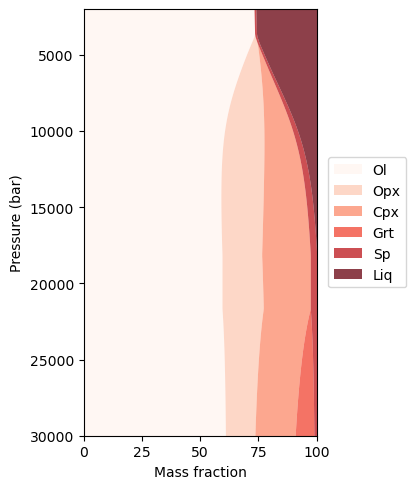

In [5]:
ptt.phase_plot(Results['pMELTS'], 
    y_axis="P_bar")

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='Mass fraction', ylabel='Pressure (bar)'>)

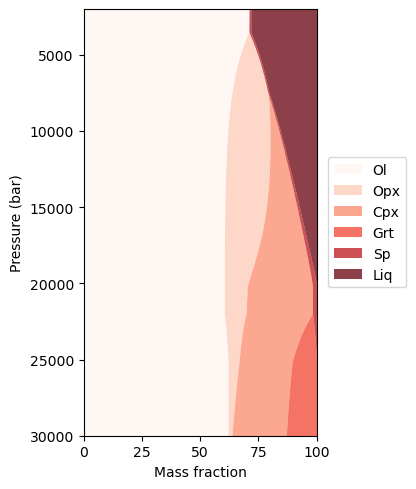

In [6]:
ptt.phase_plot(Results['Green2025'],
    y_axis="P_bar")

We can also use Thermobar (Wieser et al. 2023) to examine the mineral compositions predicted by these two models. Specifically we can plot the clinoyproxene and orthopyroxene data on a pyroxene quadrilateral.

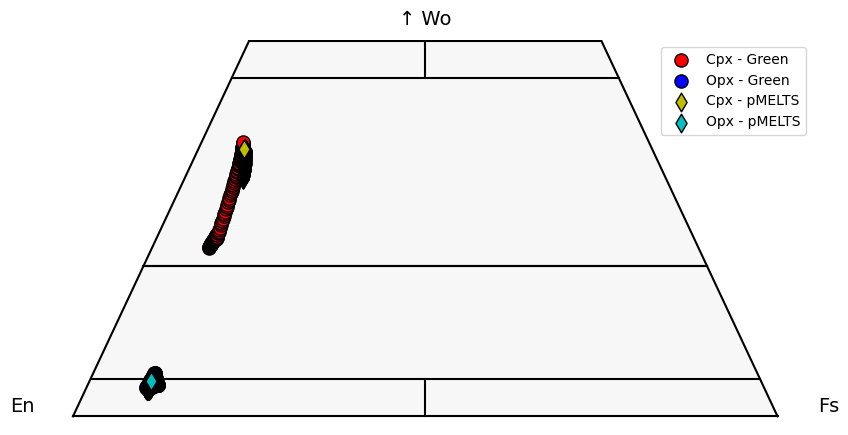

In [7]:
import ternary
import Thermobar as pt

fig, tax = pt.plot_px_classification(
    figsize=(10,5))

cpx_comps_tern_green = pt.tern_points_px(
    px_comps=Results['Green2025']['clinopyroxene1'])
tax.scatter(cpx_comps_tern_green, ec = 'k',
    marker = 'o', facecolor = 'r', s = 90,
    label = 'Cpx - Green')

opx_comps_tern_green = pt.tern_points_px(
    px_comps=Results['Green2025']['orthopyroxene1'])
tax.scatter(opx_comps_tern_green, ec = 'k',
    marker = 'o', facecolor = 'b', s = 90,
    label = 'Opx - Green')

cpx_comps_tern_melts = pt.tern_points_px(
    px_comps=Results['pMELTS']['clinopyroxene1'])
tax.scatter(cpx_comps_tern_melts, ec = 'k',
    marker = 'd', facecolor = 'y', s = 90,
    label = 'Cpx - pMELTS')

opx_comps_tern_melts = pt.tern_points_px(
    px_comps=Results['pMELTS']['orthopyroxene1'])
tax.scatter(opx_comps_tern_melts, ec = 'k',
    marker = 'd', facecolor = 'c', s = 90,
    label = 'Opx - pMELTS')

tax.legend()

However, there is ongoing debate regarding the lithology of the mantle, even in the source region of mid-ocean ridge systems, and so it might be informative to also model the melting behaviour of a pyroxenitic mantle lithology instead. To perform that calculation we can set up the model in the same way as above, but instead specify the pre-defined composition of the KG1 silica-deficient pyroxenite.

We can also go beyond 'simply' comparing the different thermodynamic models (pMELTS vs Green et al. (2025)). PetThermoTools is designed to integrate withthe empirical parameterizations for both lherzolite and pyroxenite melting in pyMelt (Matthews et al. 2022). To do so, all we need to do it chance the 'Model' parameter. The code below simulates melting of both lherzolite (KLB-1) and pyroxenite (KG1) lithologies using both the Green et al. (2025) thermodynamic model and the pyMelt empirical parameterizations from Matthews et al. (2021).

In [8]:
Model = ['pyMelt', 'Green2025']
Results_KLB = {}
Results_KG1 = {}
for m in Model:
    Results_KLB[m] = ptt.AdiabaticDecompressionMelting(Model = m, bulk = "KLB-1",
        Tp_C = 1350.0, P_start_bar = 40000.0, P_end_bar = 2000.0, dp_bar = 250.0)
    Results_KG1[m] = ptt.AdiabaticDecompressionMelting(Model = m, bulk = "KG1",
        Tp_C = 1350.0, P_start_bar = 40000.0, P_end_bar = 2000.0, dp_bar = 250.0)

Plotting the results (as pressure against melt fraction and temperature) reveals an earlier melt initiation during melting of pyroxenite lithologies in the thermodynamic models (compared to pyMelt), with an higher melt fraction at each pressure for the thermodynamic models results. Notably, our calculations indicate that the solid adiabat for a pure pyroxenitic mantle results in a signficantly higher temperature at elevated pressures (>2 GPa) than a pure lherzolitic mantle.

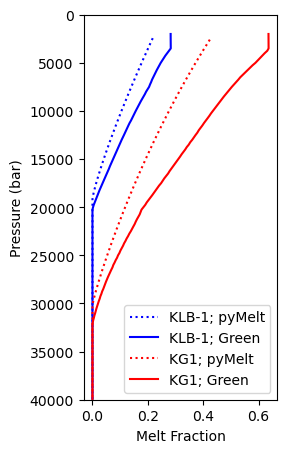

In [9]:
f, a = plt.subplots(1,1, figsize = (2.5, 5))
a.plot(Results_KLB["pyMelt"]["All"]["mass_g_Liq"],
    Results_KLB['pyMelt']['All']['P_bar'],':b',
    label='KLB-1; pyMelt')
a.plot(Results_KLB["Green2025"]["All"]["mass_g_Liq"],
    Results_KLB['Green2025']['All']['P_bar'],'-b',
    label='KLB-1; Green')

a.plot(Results_KG1["pyMelt"]["All"]["mass_g_Liq"],
    Results_KG1['pyMelt']['All']['P_bar'],':r',
    label='KG1; pyMelt')
a.plot(Results_KG1["Green2025"]["All"]["mass_g_Liq"],
    Results_KG1['Green2025']['All']['P_bar'],'-r',
    label='KG1; Green')

a.set_ylim([40000,0])
a.set_ylabel('Pressure (bar)')
a.set_xlabel('Melt Fraction')
a.legend()

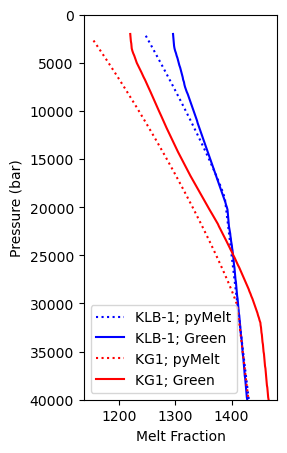

In [10]:
f, a = plt.subplots(1,1, figsize = (2.5, 5))
a.plot(Results_KLB["pyMelt"]["All"]["T_C"],
    Results_KLB['pyMelt']['All']['P_bar'],':b',
    label='KLB-1; pyMelt')
a.plot(Results_KLB["Green2025"]["All"]["T_C"],
    Results_KLB['Green2025']['All']['P_bar'],'-b',
    label='KLB-1; Green')

a.plot(Results_KG1["pyMelt"]["All"]["T_C"],
    Results_KG1['pyMelt']['All']['P_bar'],':r',
    label='KG1; pyMelt')
a.plot(Results_KG1["Green2025"]["All"]["T_C"],
    Results_KG1['Green2025']['All']['P_bar'],'-r',
    label='KG1; Green')

a.set_ylim([40000,0])
a.set_ylabel('Pressure (bar)')
a.set_xlabel('Melt Fraction')
a.legend()

## Utilizing outputs to calculate the SCSS of mantle melts

The outputs from all PetThermoTools functions are designed to integrate easily with other Python3 tools designed to facilitate petrological research (e.g., Thermobar, pyMelt, PySulfSat). A nice example of this can be found on the PySulfSat readthedocs page where fractional crystallization models at different pressures are combined with models for the sulfur content at sulfide saturation (SCSS) to determine the sulfur capacity of magmas undergoing fractional crystallization at different levels within the crust (https://pysulfsat.readthedocs.io/en/latest/Examples/Integrating_with_PyMELTS/Polybaric_FC_Model.html).

Here, we demonstrate a similar example, but instead of looking at crystallization we'll take the calculations above, which include predictions for the major element content of mantle melts produced during adiabat decompression melting beneath a mid-ocean ridge, to determine the SCSS of primary mantle melts at the pressure of melt generation. To start, we need to install (if you haven't already) and import PySulfSat.

In [11]:
# !pip install PySulfSat
import PySulfSat as ss

For this example we'll simply use the Smythe et al. (2017) SCSS model with a fixed sulfide composition. To explore how different SCSS models, or ways to determine the sulfide composition, can be modelled with PySulfSat please go to the PySulfSat readthedocs page (https://pysulfsat.readthedocs.io/en/latest/).

Without modifying the PetThermoTools outputs in any way we can use the results from the calculations above to determine the SCSS of lherozolite and pyroxenite mantle melts at the conditions of melt generation:

In [13]:
import PySulfSat as ss
Smythe17_KLB1=ss.calculate_S2017_SCSS(
    df=Results_KLB['Green2025']['All'],
    T_K=Results_KLB['Green2025']['All']['T_C']+273.15, 
    P_kbar=Results_KLB['Green2025']['All']['P_bar']/1000, 
    H2O_Liq=Results_KLB['Green2025']['All']['H2O_Liq'],Fe_FeNiCu_Sulf=0.6, 
    Fe3Fet_Liq=Results_KLB['Green2025']['All']['Fe3Fet_Liq'])

In [14]:
Smythe17_KG1=ss.calculate_S2017_SCSS(
    df=Results_KG1['Green2025']['All'], 
    T_K=Results_KG1['Green2025']['All']['T_C']+273.15, 
    P_kbar=Results_KG1['Green2025']['All']['P_bar']/1000, 
    H2O_Liq=Results_KG1['Green2025']['All']['H2O_Liq'], Fe_FeNiCu_Sulf=0.6, 
    Fe3Fet_Liq=Results_KG1['Green2025']['All']['Fe3Fet_Liq'])

To examine these results we can plot the SCSS against pressure. It is also informative to plot different chemical parameters against pressure (or directly against SCSS) to understand what components are influencing the SCSS calculations:

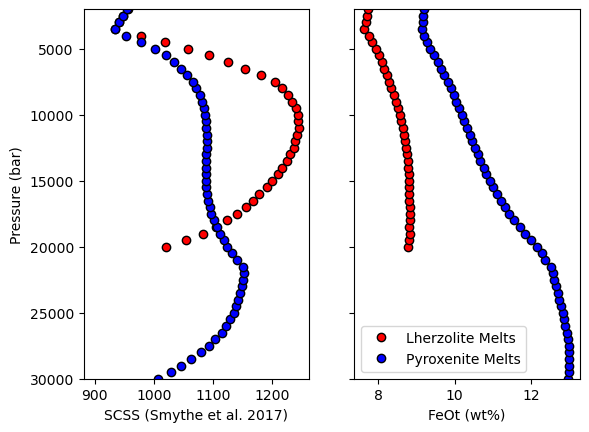

In [15]:
f, a = plt.subplots(1,2, sharey = True)
a[0].plot(Smythe17_KLB1['SCSS2_ppm_ideal_Smythe2017'],
       Results_KLB['Green2025']['All']['P_bar'], 'ok', mfc = 'r')
a[0].plot(Smythe17_KG1['SCSS2_ppm_ideal_Smythe2017'],
       Results_KG1['Green2025']['All']['P_bar'], 'ok', mfc = 'b')

a[1].plot(Results_KLB['Green2025']['All']['FeOt_Liq'],
       Results_KLB['Green2025']['All']['P_bar'], 'ok', mfc = 'r', label = 'Lherzolite Melts')
a[1].plot(Results_KG1['Green2025']['All']['FeOt_Liq'],
       Results_KG1['Green2025']['All']['P_bar'], 'ok', mfc = 'b', label = 'Pyroxenite Melts')

a[0].set_ylim([30000,2000])
a[0].set_ylabel('Pressure (bar)')
a[0].set_xlabel('SCSS (Smythe et al. 2017)')
a[1].set_xlabel('FeOt (wt%)')
a[1].legend()